In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install timm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from timm.models.layers.adaptive_avgmax_pool import SelectAdaptivePool2d
from torch.nn import Flatten

from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai.callback.fp16 import *

#import pydicom
#!pip install -qU python-gdcm pydicom pylibjpeg

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [60]:
df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [61]:
df['filepath'] = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/' + df['patient_id'].astype(str) + '/' + df['image_id'].astype(str) + '.png'
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,filepath
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1459541791.png
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1864590858.png
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1874946579.png
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10011/220375232.png


In [62]:
df.iloc[0,-1]

'/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/462822612.png'

In [63]:
df.density.value_counts()

B    12651
C    12175
A     3105
D     1539
Name: density, dtype: int64

In [64]:
df = df[['filepath', 'cancer']]
df.head()

,filepath,cancer
0,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/462822612.png,0
1,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1459541791.png,0
2,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1864590858.png,0
3,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1874946579.png,0
4,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10011/220375232.png,0


In [65]:
df.cancer.value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

# Train Test Split

In [66]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets, stratified by the "target" column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cancer'], random_state=1)
print('shape of train_df', train_df.shape)
print('shape of test_df', test_df.shape)

shape of train_df (43764, 2)
shape of test_df (10942, 2)


# Sampling

In [67]:
# Class count
count_class_0, count_class_1 = train_df.cancer.value_counts()

# Divide by class
df_class_0 = train_df[train_df['cancer'] == 0]
df_class_1 = train_df[train_df['cancer'] == 1]

In [68]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1, random_state=1)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

df_train_under = df_train_under.sample(frac=1, random_state=1)

print('Random under-sampling:')
print(df_train_under.cancer.value_counts())

Random under-sampling:
0    926
1    926
Name: cancer, dtype: int64


In [69]:
df_train_under.shape

(1852, 2)

In [70]:
df_train_under.dtypes

filepath    object
cancer       int64
dtype: object

In [71]:
df_train_under.head()

,filepath,cancer
52407,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/7420/2115590764.png,0
49547,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/63453/957012839.png,1
10972,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/2179/2039865970.png,1
8990,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/1963/1044828729.png,1
50723,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/64714/713892833.png,0


# Training

In [72]:
db = DataBlock(blocks=(ImageBlock(), CategoryBlock),
                   get_x=lambda x:x[0],
                   get_y=lambda x:x[1],
                   splitter  = RandomSplitter(seed=1))

dls = db.dataloaders(df_train_under.values, num_workers=0, bs=32)

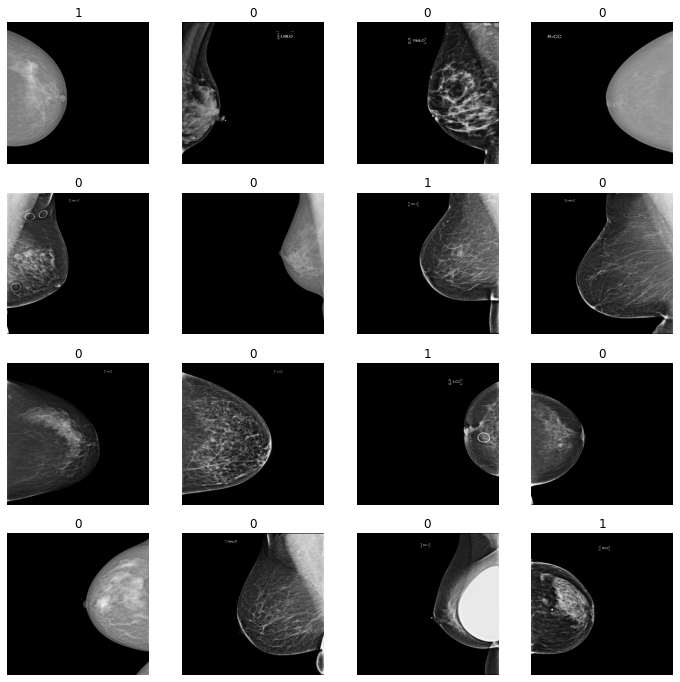

In [73]:
dls.show_batch(max_n=16)

In [74]:
def get_learner(arch=resnet18):
    learner = vision_learner(
        dls,
        arch,
        custom_head=nn.Sequential(SelectAdaptivePool2d(pool_type='avg', flatten=Flatten()), nn.Linear(1280, 2)),
        metrics=[
            error_rate
        ],
        #loss_func=CrossEntropyLossFlat(weight=torch.tensor([1,50]).float()),
        pretrained=True,
        #normalize=False
    ).to_fp16()
    return learner

In [75]:
learn = get_learner('tf_efficientnetv2_s')

In [76]:
learn.load('/kaggle/input/us-512/us_512_ch_enet_ft')

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


# Validation Data Metric

In [77]:
# # # interp = ClassificationInterpretation.from_learner(learn)
# # # losses,idxs = interp.top_losses()
# # # len(dls.valid_ds)==len(losses)==len(idxs)
# # # interp.plot_confusion_matrix(figsize=(7,7))

# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix()

In [78]:
#interp.plot_top_losses(5, nrows=1)

# Test Data Metric

In [79]:
# Class count
count_class_0_test, count_class_1_test = test_df.cancer.value_counts()

# Divide by class
df_class_0_test = test_df[test_df['cancer'] == 0]
df_class_1_test = test_df[test_df['cancer'] == 1]

In [80]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under_test = df_class_0_test.sample(count_class_1_test, random_state=1)
df_test_under = pd.concat([df_class_0_under_test, df_class_1_test], axis=0)

print('Random under-sampling:')
print(df_test_under.cancer.value_counts())

Random under-sampling:
0    232
1    232
Name: cancer, dtype: int64


In [81]:
df_test_under.head()

,filepath,cancer
15529,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/26530/166085523.png,0
40435,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/53674/1819593490.png,0
47530,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/61124/819815398.png,0
15493,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/26479/29776948.png,0
48804,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/62627/180735505.png,0


In [24]:
temp = learn.predict('/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_dicomsdl_512/train_images_processed_cv2_dicomsdl_512/10006/1459541791.png')
temp[0]

'0'

In [25]:
def pfbeta(labels, predictions, beta):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(int(predictions[idx]), 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

In [26]:
df_test_under.shape

(464, 2)

In [27]:
from tqdm import tqdm
from IPython.display import clear_output

labels = []
preds = []

#preds = learn.predict(test_df['filepath'])
#labels = test_df['cancer']

for _, row in tqdm(df_test_under.iterrows()):
    pred = int(learn.predict(row.filepath)[0])
    preds.append(pred)
    label = row.cancer
    labels.append(label)
    clear_output(wait=True)

464it [00:38, 12.04it/s]


In [28]:
type(pred)

int

In [29]:
score = pfbeta(labels=labels, predictions=preds, beta=1)
print(score)

0.582392776523702


In [30]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels, preds)

array([[150,  82],
       [103, 129]])

# Pipeline check

In [31]:
df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [32]:
#/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1459541791.dcm

In [33]:
df['filepath'] = '/kaggle/input/rsna-breast-cancer-detection/train_images/' + df['patient_id'].astype(str) + '/' + df['image_id'].astype(str) + '.dcm'
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,filepath
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/train_images/10006/462822612.dcm
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1459541791.dcm
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1864590858.dcm
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1874946579.dcm
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/train_images/10011/220375232.dcm


In [34]:
#df = df[['filepath', 'cancer']]
#df.head()

In [35]:
df.cancer.value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

In [36]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets, stratified by the "target" column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cancer'], random_state=1)
print('shape of train_df', train_df.shape)
print('shape of test_df', test_df.shape)

shape of train_df (43764, 15)
shape of test_df (10942, 15)


In [37]:
# Class count
count_class_0_test, count_class_1_test = test_df.cancer.value_counts()

# Divide by class
df_class_0_test = test_df[test_df['cancer'] == 0]
df_class_1_test = test_df[test_df['cancer'] == 1]

In [38]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under_test = df_class_0_test.sample(count_class_1_test, random_state=1)
df_test_under = pd.concat([df_class_0_under_test, df_class_1_test], axis=0)

print('Random under-sampling:')
print(df_test_under.cancer.value_counts())

Random under-sampling:
0    232
1    232
Name: cancer, dtype: int64


In [56]:
df_test_under.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,filepath
15529,1,26530,166085523,L,AT,41.0,0,0,0,1.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-detection/train_images/26530/166085523.dcm
40435,1,53674,1819593490,R,MLO,63.0,0,0,0,NaN,0,D,49,False,/kaggle/input/rsna-breast-cancer-detection/train_images/53674/1819593490.dcm
47530,2,61124,819815398,L,CC,63.0,0,0,0,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-detection/train_images/61124/819815398.dcm
15493,1,26479,29776948,L,MLO,73.0,0,0,0,1.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/train_images/26479/29776948.dcm
48804,1,62627,180735505,L,CC,48.0,0,0,0,1.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-detection/train_images/62627/180735505.dcm


In [58]:
df_test_under[df_test_under.index==15529]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,filepath
15529,1,26530,166085523,L,AT,41.0,0,0,0,1.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-detection/train_images/26530/166085523.dcm


In [39]:
image_dir_dicomsdl = '/kaggle/working/png_file_dic/'

os.makedirs(image_dir_dicomsdl, exist_ok=True)

#IMAGES_TO_PROCESS = 500

In [40]:
test_images=[]

for _, row in tqdm(df_test_under.iterrows()):
    test_images.append(row.filepath)

464it [00:00, 17091.49it/s]


In [42]:
print(len(test_images))
test_images[0]

464


'/kaggle/input/rsna-breast-cancer-detection/train_images/26530/166085523.dcm'

In [43]:
!pip install /kaggle/input/dicomsdl-offline-installer/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl

Processing /kaggle/input/dicomsdl-offline-installer/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


In [44]:
import dicomsdl as dicoml
import cv2
import pydicom

from joblib import Parallel, delayed
import glob
import time
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

In [46]:
def process(f, size=512, save_folder=None, extension="png"):
    
    patient = f.split('/')[-2]
    image_name = f.split('/')[-1][:-4]
    
    dicom = dicoml.open(f)
    img = dicom.pixelData()

    img = (img - img.min()) / (img.max() - img.min())

    if dicom.getPixelDataInfo()['PhotometricInterpretation'] == "MONOCHROME1":
        img = 1 - img

    image = (img * 255).astype(np.uint8)
    
    img = cv2.resize(image, (size, size))

    file_name = f'{save_folder}' + f"{patient}_{image_name}.{extension}"

    cv2.imwrite(file_name, img)

In [47]:
Parallel(n_jobs=4)(
    delayed(process)(f, size = 512, save_folder = image_dir_dicomsdl)
    for f in test_images
)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [50]:
prediction_ids = []
preds = []
labels = []

for _, row in tqdm(df_test_under.iterrows()):
    #prediction_ids.append(row.prediction_id)
    pred_image_path = image_dir_dicomsdl + str(row.patient_id) + '_' + str(row.image_id) + '.png'
    pred = int(learn.predict(pred_image_path)[0])
    preds.append(pred)
    labels.append(row.cancer)
    clear_output(wait=True)

#submission = pd.DataFrame(data={'prediction_id': prediction_ids, 'cancer': preds}).groupby('prediction_id').max().reset_index()
#submission.head()

464it [00:51,  9.09it/s]


In [55]:
pred_image_path

'/kaggle/working/png_file_dic/60033_1188802546.png'

In [51]:
def pfbeta(labels, predictions, beta):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(int(predictions[idx]), 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

In [52]:
df_test_under.shape

(464, 15)

In [53]:
score = pfbeta(labels=labels, predictions=preds, beta=1)
print(score)

0.5982142857142857


In [54]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels, preds)

array([[150,  82],
       [ 98, 134]])